In [0]:
import numpy as np
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import sympy
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing

In [0]:
# to format Latex output with mathjax
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sympy.printing.latex(exp,**options)
init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)


**Extended Kalman Filter Implementation for Constant Heading and Velocity (CHCV) Vehicle Model in Python**


Wikipedia writes: In the extended Kalman filter, the state transition and observation models need not be linear functions of the state but may instead be differentiable functions.

$\boldsymbol{x}_{k} = g(\boldsymbol{x}_{k-1}, \boldsymbol{u}_{k-1}) + \boldsymbol{w}_{k-1}$

$\boldsymbol{z}_{k} = h(\boldsymbol{x}_{k}) + \boldsymbol{v}_{k}$

Where $w_k$ and $v_k$ are the process and observation noises which are both assumed to be zero mean Multivariate Gaussian noises with covariance matrix $Q$ and $R$ respectively.

The function $g$ can be used to compute the predicted state from the previous estimate and similarly the function $h$ can be used to compute the predicted measurement from the predicted state. However, $g$ and $h$ cannot be applied to the covariance directly. Instead a matrix of partial derivatives (the Jacobian matrix) is computed.

At each time step, the Jacobian is evaluated with current predicted states. These matrices can be used in the Kalman filter equations. This process essentially linearizes the non-linear function around the current estimate.

State Vector - Constant Heading and Velocity Model (CHCV)
Situation covered: You have a position sensor, which measures the vehicle position ($x$ & $y$) and you try to estimate the heading and the velocity.

Constant Heading, Constant Velocity Model

$$ x_k= \begin{bmatrix} x^{*} \\ y^{*} \\ \psi \\ v \end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \end{bmatrix} $$
$^{*}$=actually measured values in this implementation example!

In [0]:
numstates=4 # States

Developing the math behind dynamic model \\
All symbolic calculations are made with Sympy. Thanks!

In [0]:
vs, psis, dts, xs, ys, lats, lons = symbols('v \psi T x y lat lon')

gs = Matrix([[xs+vs*dts*cos(psis)],
             [ys+vs*dts*sin(psis)],
             [psis],
             [vs]])
state = Matrix([xs,ys,psis,vs])

Dynamic Function $g$ \\
This formulas calculate how the state is evolving from one to the next time step

In [5]:
gs

⎡T⋅v⋅cos(\psi) + x⎤
⎢                 ⎥
⎢T⋅v⋅sin(\psi) + y⎥
⎢                 ⎥
⎢      \psi       ⎥
⎢                 ⎥
⎣        v        ⎦

Calculate the Jacobian of the Dynamic function $g$ with respect to the state vector $x$

In [6]:
state

⎡ x  ⎤
⎢    ⎥
⎢ y  ⎥
⎢    ⎥
⎢\psi⎥
⎢    ⎥
⎣ v  ⎦

In [7]:
gs.jacobian(state)

⎡1  0  -T⋅v⋅sin(\psi)  T⋅cos(\psi)⎤
⎢                                 ⎥
⎢0  1  T⋅v⋅cos(\psi)   T⋅sin(\psi)⎥
⎢                                 ⎥
⎢0  0        1              0     ⎥
⎢                                 ⎥
⎣0  0        0              1     ⎦

Initial Uncertainty $P_0$ \\
Initialized with $0$ means you are pretty sure where the vehicle starts

In [8]:
P = np.eye(numstates)*1000.0
print(P, P.shape)

[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)


Process Noise Covariance Matrix $Q$ \\
"The state uncertainty model models the disturbances which excite the linear system. Conceptually, it estimates how bad things can get when the system is run open loop for a given period of time." - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853
\\
Because this depends on the dt, it has to be calculated in every filterstep.

**Real Measurements**

In [9]:
!ls *.csv

ls: cannot access '*.csv': No such file or directory


In [10]:
!wget https://raw.githubusercontent.com/balzer82/Kalman/master/2014-03-26-000-Data.csv

--2020-01-01 14:55:19--  https://raw.githubusercontent.com/balzer82/Kalman/master/2014-03-26-000-Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1887196 (1.8M) [text/plain]
Saving to: ‘2014-03-26-000-Data.csv’

2014-03-26-000-Data 100%[===================>]   1.80M  --.-KB/s    in 0.09s   

2020-01-01 14:55:19 (20.3 MB/s) - ‘2014-03-26-000-Data.csv’ saved [1887196/1887196]



In [11]:
datafile = '2014-03-26-000-Data.csv'

date, \
time, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True,skiprows=1)

print('Read \'%s\' successfully.' % datafile)

# A course of 0° means the Car is traveling north bound
# and 90° means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90°
# We need an offset.
course =(-course+90.0)

Read '2014-03-26-000-Data.csv' successfully.


**Calculate dt for Measurements**

In [0]:
dt = np.hstack([0.02, np.diff(millis)])/1000.0 # in s


Measurement Function $h$ \\
Matrix $J_H$ is the Jacobian of the Measurement function $h$ with respect to the state. Function $h$ can be used to compute the predicted measurement from the predicted state. \\

If a GPS measurement is available, the following function maps the state to the measurement.

In [13]:
hs = Matrix([[xs],
             [ys]])
hs

⎡x⎤
⎢ ⎥
⎣y⎦

In [14]:
JHs=hs.jacobian(state)
JHs

⎡1  0  0  0⎤
⎢          ⎥
⎣0  1  0  0⎦

If no GPS measurement is available, simply set the corresponding values in $J_h$ to zero.

**Measurement Noise Covariance $R$** \\
"In practical use, the uncertainty estimates take on the significance of relative weights of state estimates and measurements. So it is not so much important that uncertainty is absolutely correct as it is that it be relatively consistent across all models" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

In [15]:
varGPS = 6.0 # Standard Deviation of GPS Measurement
R = np.diag([varGPS**2.0, varGPS**2.0])

print(R, R.shape)

[[36.  0.]
 [ 0. 36.]] (2, 2)


**Identity Matrix**

In [16]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


**Approx. Lat/Lon to Meters to check Location**

In [0]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

**Initial State**

In [18]:
x = np.matrix([[mx[0], my[0], 0.5*np.pi, 0.0]]).T
print(x, x.shape)

[[0.        ]
 [0.        ]
 [1.57079633]
 [0.        ]] (4, 1)


**Put everything together as a measurement vector**

In [19]:
measurements = np.vstack((mx, my))
# Length of the measurement
m = measurements.shape[1]
print(measurements.shape)

(2, 10800)


In [0]:
# Preallocation for Plotting
x0, x1, x2, x3 = [], [], [], []
Zx, Zy = [], []
Px, Py, Pdx, Pdy = [], [], [], []
Kx, Ky, Kdx, Kdy = [], [], [], []

def savestates(x, Z, P, K):
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))

In [0]:
for filterstep in range(m):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    x[0] = x[0] + dt[filterstep]*x[3]*np.cos(x[2])
    x[1] = x[1] + dt[filterstep]*x[3]*np.sin(x[2])
    x[2] = (x[2]+ np.pi) % (2.0*np.pi) - np.pi
    x[3] = x[3]

    type(x[0])
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = -dt[filterstep]*x[3]*np.sin(x[2])
    a14 = dt[filterstep]*np.cos(x[2])
    a23 = dt[filterstep]*x[3]*np.cos(x[2])
    a24 = dt[filterstep]*np.sin(x[2])
    JA = np.matrix([[1.0, 0.0, a13, a14],
                    [0.0, 1.0, a23, a24],
                    [0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 1.0]])
    
    
    # Calculate the Process Noise Covariance Matrix
    sGPS     = 0.5*8.8*dt[filterstep]**2  # assume 8.8m/s2 as maximum acceleration
    sCourse  = 2.0*dt[filterstep] # assume 0.5rad/s as maximum turn rate
    sVelocity= 35.0*dt[filterstep] # assume 8.8m/s2 as maximum acceleration

    Q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2])
    
    # Project the error covariance ahead
    P = JA*P*JA.T + Q

        # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])]])

    if GPS[filterstep]: # with 10Hz, every 5th step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0]])
    else: # every other step
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0]])        
        
    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S.astype(float))

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual

    inter = K*y
    inter = inter.astype(float)
    x = x + inter


    # Update the error covariance
    P = (I - (K*JH))*P

    # Save states for Plotting
    savestates(x, Z, P, K)

In [0]:
def plotP():
    fig = plt.figure(figsize=(16,9))
    plt.semilogy(range(m),Px, label='$x$')
    plt.step(range(m),Py, label='$y$')
    plt.step(range(m),Pdx, label='$\psi$')
    plt.step(range(m),Pdy, label='$v$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

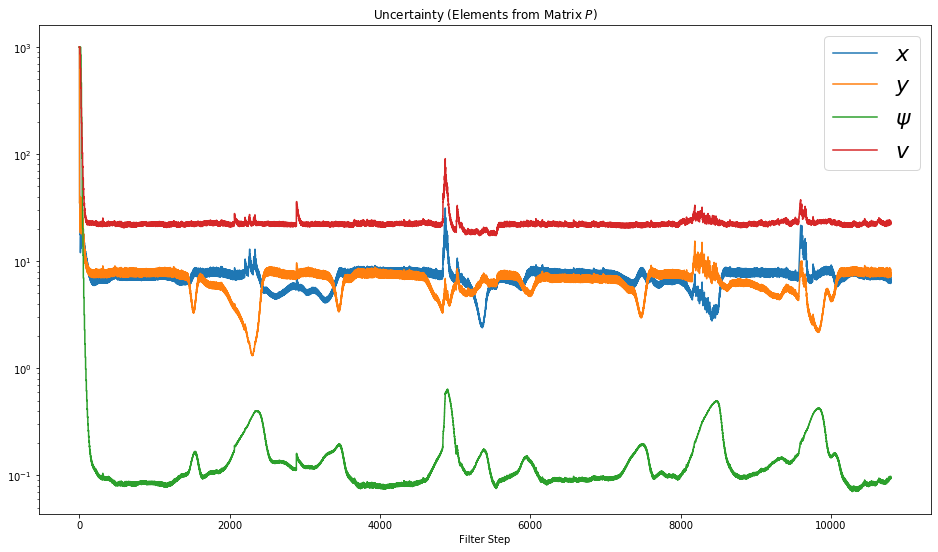

In [23]:
plotP()

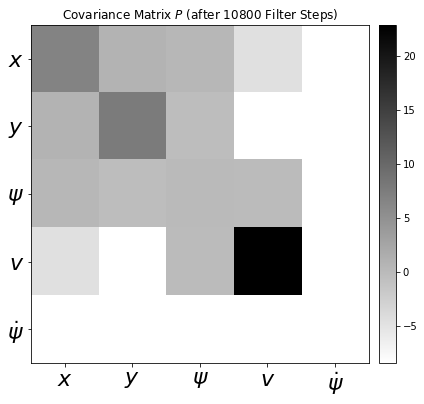

In [25]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P.astype(float), interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

**State Vector**

In [0]:
def plotx():
    fig = plt.figure(figsize=(16,16))

    plt.subplot(311)
    plt.step(range(len(measurements[0])),x0-mx[0], label='$x$')
    plt.step(range(len(measurements[0])),x1-my[0], label='$y$')

    plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel('Position (relative to start) [m]')

    plt.subplot(312)
    plt.step(range(len(measurements[0])),x2, label='$\psi$')
    plt.step(range(len(measurements[0])),
             (course/180.0*np.pi+np.pi)%(2.0*np.pi) - np.pi,
             label='$\psi$ (from GPS as reference)')
    plt.ylabel('Course')
    plt.legend(loc='best',prop={'size':16})

    plt.subplot(313)
    plt.step(range(len(measurements[0])),x3, label='$v$')
    plt.step(range(len(measurements[0])),speed/3.6,
             label='$v$ (from GPS as reference)')
    plt.ylabel('Velocity')
    #plt.ylim([0, 30])
    plt.legend(loc='best',prop={'size':16})
    plt.xlabel('Filter Step')

    plt.savefig('Extended-Kalman-Filter-CHCV-State-Estimates.png',
                dpi=72, transparent=True, bbox_inches='tight')

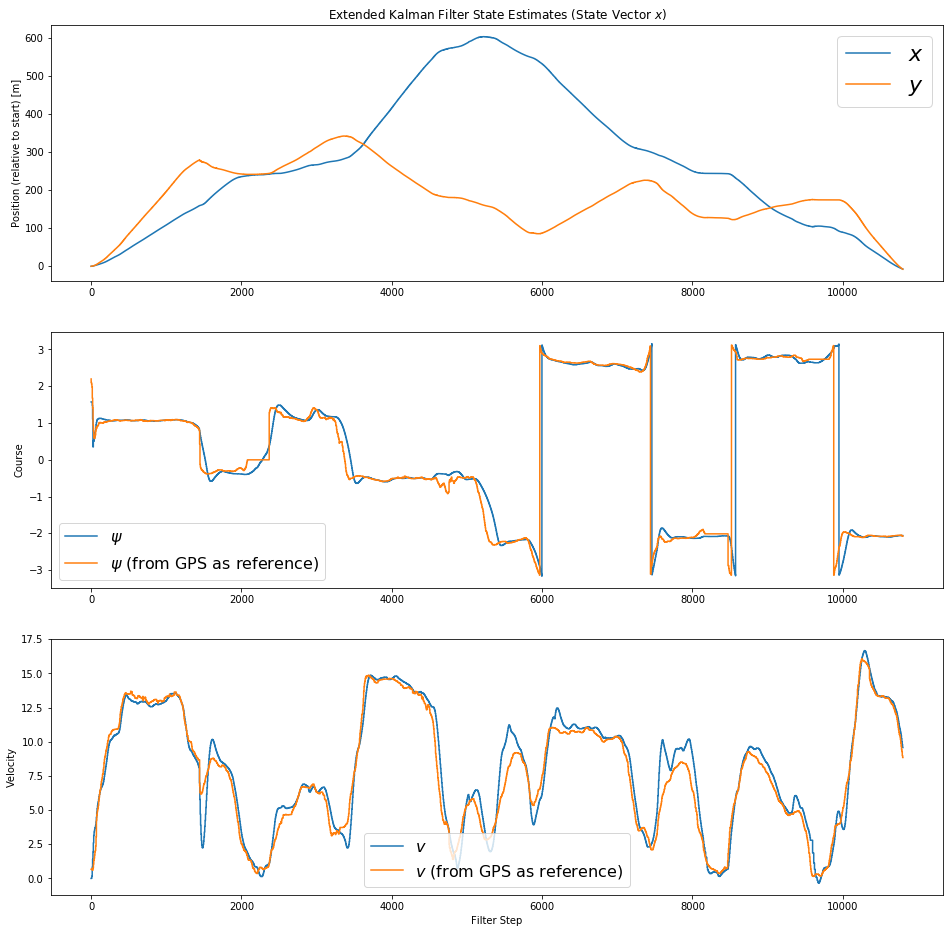

In [27]:
plotx()

**Position x/y**

In [0]:
def plotxy():

    fig = plt.figure(figsize=(16,9))

    # EKF State
    plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600',
               units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    # Start/Goal
    plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
    plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')
    #plt.tight_layout()

    plt.savefig('Extended-Kalman-Filter-CHCV-Position.png',
                dpi=72, transparent=True, bbox_inches='tight')

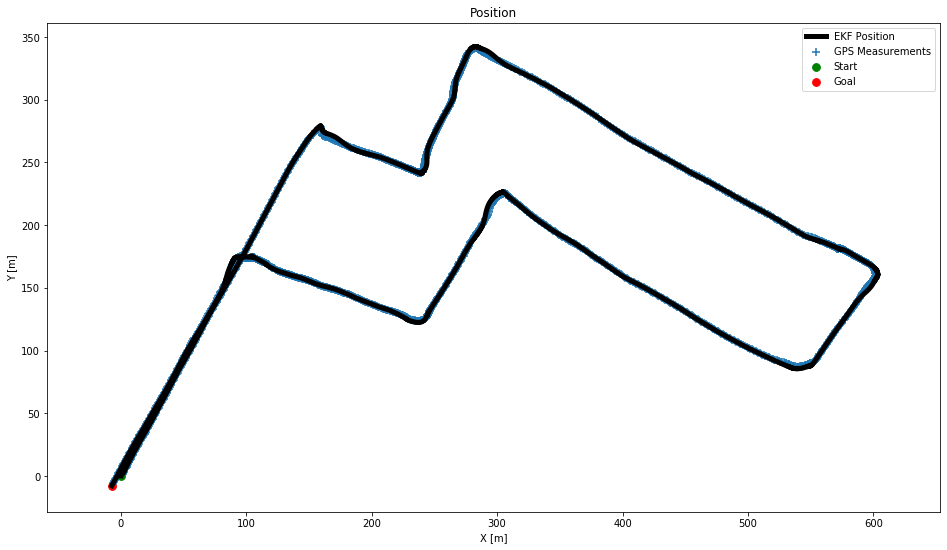

In [29]:
plotxy()

**Detailed View**

In [0]:
def plotxydetails():
    fig = plt.figure(figsize=(12,9))

    plt.subplot(221)
    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(70, 130)
    plt.ylabel('Y [m]')
    plt.ylim(140, 200)
    plt.title('Position')
    plt.legend(loc='best')


    plt.subplot(222)

    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(160, 260)
    plt.ylabel('Y [m]')
    plt.ylim(110, 160)
    plt.title('Position')
    plt.legend(loc='best')

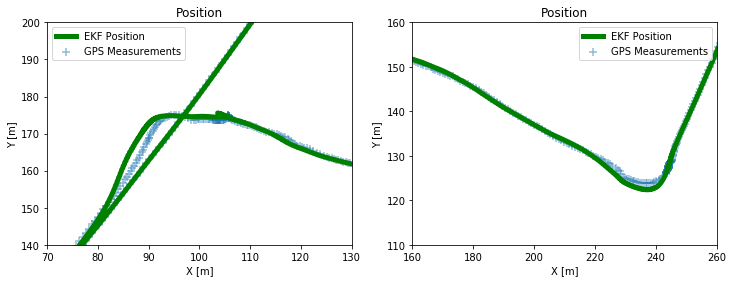

In [31]:
plotxydetails()

Write Google Earth KML \\
Convert back from Meters to Lat/Lon (WGS84)

In [0]:
latekf = latitude[0] + np.divide(x1,arc)
lonekf = longitude[0]+ np.divide(x0,np.multiply(arc,np.cos(latitude*np.pi/180.0)))

Create Data for KML Path \\
Coordinates and timestamps to be used to locate the car model in time and space The value can be expressed as yyyy-mm-ddThh:mm:sszzzzzz, where T is the separator between the date and the time, and the time zone is either Z (for UTC) or zzzzzz, which represents ±hh:mm in relation to UTC.

In [0]:
import datetime
car={}
car['when']=[]
car['coord']=[]
car['gps']=[]
for i in range(len(millis)):
    d=datetime.datetime.fromtimestamp(millis[i]/1000.0)
    car["when"].append(d.strftime("%Y-%m-%dT%H:%M:%SZ"))
    car["coord"].append((lonekf[i], latekf[i], 0))
    car["gps"].append((longitude[i], latitude[i], 0))

In [36]:
!pip install simplekml

  Created wheel for simplekml: filename=simplekml-1.3.1-cp36-none-any.whl size=51047 sha256=65ec142fc0deb68d7f19eb0e389936064185693fa5d4af881c0fe3aef5501f97
  Stored in directory: /root/.cache/pip/wheels/12/12/8f/9e22dd924dc3cedb41f9888379000713e980478437af610d0e
Successfully built simplekml


In [0]:
from simplekml import Kml, Model, AltitudeMode, Orientation, Scale, Style, Color

In [0]:
# The model path and scale variables
car_dae = r'https://raw.githubusercontent.com/balzer82/Kalman/master/car-model.dae'
car_scale = 1.0

# Create the KML document
kml = Kml(name=d.strftime("%Y-%m-%d %H:%M"), open=1)

# Create the model
model_car = Model(altitudemode=AltitudeMode.clamptoground,
                            orientation=Orientation(heading=75.0),
                            scale=Scale(x=car_scale, y=car_scale, z=car_scale))

# Create the track
trk = kml.newgxtrack(name="EKF", altitudemode=AltitudeMode.clamptoground,
                     description="State Estimation from Extended Kalman Filter with CHCV Model")

# Attach the model to the track
trk.model = model_car
trk.model.link.href = car_dae

# Add all the information to the track
trk.newwhen(car["when"])
trk.newgxcoord(car["coord"])

# Style of the Track
trk.iconstyle.icon.href = ""
trk.labelstyle.scale = 1
trk.linestyle.width = 4
trk.linestyle.color = '7fff0000'

# Add GPS measurement marker
fol = kml.newfolder(name="GPS Measurements")
sharedstyle = Style()
sharedstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'

for m in range(len(latitude)):
    if GPS[m]:
        pnt = fol.newpoint(coords = [(longitude[m],latitude[m])])
        pnt.style = sharedstyle

# Saving
#kml.save("Extended-Kalman-Filter-CTRV.kml")
kml.savekmz("Extended-Kalman-Filter-CHCV.kmz")